# Test the 4 class classifier
Compared to the google paper:

##### Look at the training and validation error of the models:

In [1]:
import pickle
from keras.models import load_model
import os
import sys
import numpy as np
import pandas as pd
import glob
import random
from PIL import Image
import matplotlib.pyplot as plt
# path='/Users/rb/Google_Drive/Waterloo/projects/cancer_hist/output/model_conv1'
# path='/Users/rb/Google_Drive/Waterloo/projects/cancer_hist/output/model_conv_fc2'
# path='/Users/rb/Google_Drive/Waterloo/projects/cancer_hist/output/model_conv_fc3'



everything=glob.glob(os.path.join(path, '*'))

all_hist = [loc for loc in everything if '.hdf5' not in loc]

for data_loc in all_hist:
    data = pickle.load(open( data_loc, "rb" ))
    name = data_loc.rsplit('/', 1)[-1]
    print name, 'Final 5 Epochs Validation loss: ', np.mean(data['val_acc'][-5:])
    print name, 'Epoch 100 avg Validation loss: ', np.mean(data['val_acc'][100:105])
    plt.plot(data['loss'])    
    plt.plot(data['acc'])
    plt.plot(data['val_acc'])
    plt.title(name)
    plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Train acc', 'val_acc'], loc='upper left')
    plt.figure(figsize=(40,10))
    plt.show()

Using TensorFlow backend.


NameError: name 'path' is not defined

## Heatmap
* Use the pre-trained network, apply it across the entire image with stride of x. 
* Output is a heatmap of dimensions original image/x, with 4 channels representing the probabilities for each of the four classes

The feature maps are:
1. None
2. lymphocyte
3. normal_epithelial
4. malignant_epithelial

## Heatmap -> locations
* To generate locations we used non-maxima supression.
* Identify points using non-min supression on the 1st heatmap
* Use a cutoff of p
* Assign each of these a class using the max of the other 4 points

## How to test localization and classification?
* Use same mathodology as in the Sunnybrook paper
* Assign the label of the groundtruth training set to the nearest predicted cluster, as long as it is less that 10 pixels away.
* This assigned nuclei is then removed from the list of available nuclei to be assigned.

#### First visualize some heatmaps:

image.shape (463, 624, 3)
len(true_pts) 381
len(points) 438


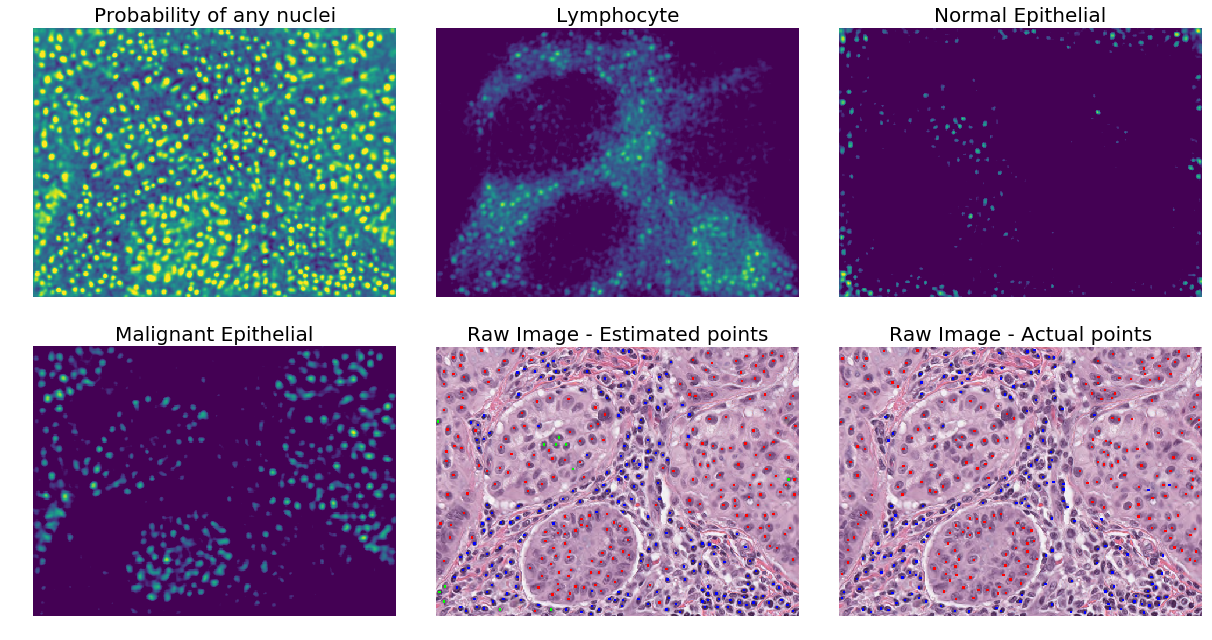

In [53]:
import sys
sys.path.insert(0, '/Users/rb/Google_Drive/Waterloo/projects/cancer_hist/src')
from functions import*
from heat_models import*
import matplotlib.pyplot as plt
% matplotlib inline

# Look at 134_Region_1
# 17_Region_60_crop

image_loc = '/Users/rb/Documents/waterloo/projects/cancer_hist/final/full_slides/test/3_Region_10_crop.tif'
heat_loc='/Users/rb/Documents/waterloo/projects/cancer_hist/final/heat_conv_incp3_192/test/3_Region_10_crop.npy'
xml_loc = '/Users/rb/Documents/waterloo/projects/cancer_hist/final/full_slides/test/3_Region_10_key.xml'

image = np.asarray(Image.open(image_loc))
heat = np.load(heat_loc)
true_pts = get_points_xml(xml_loc)
points = non_max_supression(heatmap=heat, radius=5, cutoff = .99, stride = 2)
print 'image.shape', image.shape
print 'len(true_pts)', len(true_pts)
print 'len(points)', len(points)


f = plt.figure(figsize=(17, 9))
sp = f.add_subplot(2, 6//2, 1)
sp.axis('Off')
sp.set_title('Probability of any nuclei', fontsize=20)
plt.tight_layout()
plt.imshow(heat[:,:,0])

sp = f.add_subplot(2, 6//2, 2)
sp.axis('Off')
sp.set_title('Lymphocyte', fontsize=20)
plt.tight_layout()
plt.imshow(heat[:,:,1])

sp = f.add_subplot(2, 6//2, 3)
sp.axis('Off')
sp.set_title('Normal Epithelial', fontsize=20)
plt.tight_layout()
plt.imshow(heat[:,:,2])

sp = f.add_subplot(2, 6//2, 4)
sp.axis('Off')
sp.set_title('Malignant Epithelial', fontsize=20)
plt.tight_layout()
plt.imshow(heat[:,:,3])

sp = f.add_subplot(2, 6//2, 5)
sp.axis('Off')
sp.set_title('Raw Image - Estimated points', fontsize=20)
image2 = np.array(image)
for row in range(len(points)):
    if points[row, 2] == 1:
        color = [0, 0, 255]
    elif points[row, 2] == 2:
        color = [0, 255, 0]  
    elif points[row, 2] == 3:
        color = [255, 0, 0]
    image2[int(points[row, 0])-2:int(points[row, 0])+2, int(points[row, 1])-2:int(points[row, 1])+2, :] = color
plt.tight_layout()
plt.imshow(image2)

sp = f.add_subplot(2, 6//2, 6)
sp.axis('Off')
sp.set_title('Raw Image - Actual points', fontsize=20)
image2 = np.array(image)
for row in range(len(true_pts)):
    if true_pts[row, 2] == 1:
        color = [0, 0, 255]
    elif true_pts[row, 2] == 2:
        color = [0, 255, 0]  
    elif true_pts[row, 2] == 3:
        color = [255, 0, 0]
    image2[int(true_pts[row, 0])-2:int(true_pts[row, 0])+2, int(true_pts[row, 1])-2:int(true_pts[row, 1])+2, :] = color
plt.tight_layout()
plt.imshow(image2)

## Check the accuracy of this
* No clear accuracy measure to use with this
* We will always have a high false positive rate because not all cells in the data are labeled
* Details of how this is optimizaed are in the non-maximum supression notebook.


In [9]:
import sys
sys.path.insert(0, '/Users/rb/Google_Drive/Waterloo/projects/cancer_hist/src')
from functions import*
from heat_models import*

test_folder = '/Users/rb/Documents/waterloo/projects/cancer_hist/final/full_slides/test'
heat_folder = '/Users/rb/Documents/waterloo/projects/cancer_hist/final/heat_conv_incp3_192/test'
cutoff=.99
radius = (5, 5, 5)

acc=test_heat_preds(test_folder=test_folder, heat_folder=heat_folder, radius=radius, cutoff=cutoff, output_class=True, stride=2)

print '% matched / total true: ', len(acc["all_matched_pts"])/float(acc["total_nuclei"])
print '% pred, not matched / total true: ', (float(acc["num_predicted"])-len(acc["all_matched_pts"]))/float(acc["total_nuclei"])

print acc["total_nuclei"]
print acc["num_predicted"]

% matched / total true:  0.862754452926
% pred, not matched / total true:  0.465012722646
6288
8349


0.945622119816


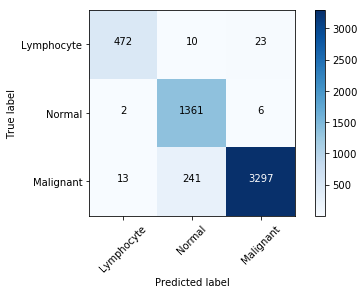

In [10]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import itertools


print(accuracy_score(acc["all_matched_pts"][:,2], acc["all_matched_preds"]))

cm = confusion_matrix(acc["all_matched_pts"][:,2], acc["all_matched_preds"])
classes =['Lymphocyte', 'Normal', 'Malignant']

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
# add the numbers
thresh = cm.max() / 2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [75]:
# LYMPHOCYTE
acc = np.float((np.sum(cm[0, 0]) + np.sum(cm[1:, 1:])))/np.float(np.sum(cm))
# TP/(TP+FN) proportion of positives that are correctly identified as such
sensitivity = np.float(np.sum(cm[0, 0]))/np.float(np.sum(cm[0, :]))
# TN/(TN+FP) prop of negative correctly identified
specificity = np.float(np.sum(cm[1:, 1:]))/np.float(np.sum(cm[1:, :]))
print 'Lymphocyte: ', acc, sensitivity, specificity

# NORMAL
acc = np.float(cm[1, 1] + cm[0, 0]+ cm[0, 2]+ cm[2, 0]+ cm[2, 2])/np.float(np.sum(cm))
# TP/(TP+FN) proportion of positives that are correctly identified as such
sensitivity = np.float(np.sum(cm[1, 1]))/np.float(np.sum(cm[1,:]))
# TN/(TN+FP) prop of negative correctly identified
specificity = np.float(np.float(cm[0, 0]+ cm[0, 2]+ cm[2, 0]+ cm[2, 2]))/np.float(np.sum(cm[0, :])+np.sum(cm[2, :]))
print 'Normal: ', acc, sensitivity, specificity

# MALIGNANT
acc = np.float((np.sum(cm[2, 2]) + np.sum(cm[:2, :2])))/np.float(np.sum(cm))
# TP/(TP+FN) proportion of positives that are correctly identified as such
sensitivity = np.float(np.sum(cm[2, 2]))/np.float(np.sum(cm[2, :]))
# TN/(TN+FP) prop of negative correctly identified
specificity = np.float(np.sum(cm[:2, :2]))/np.float(np.sum(cm[:2, :]))
print 'Malignant: ', acc, sensitivity, specificity                    

Lymphocyte:  0.991152073733 0.934653465347 0.996951219512
Normal:  0.952258064516 0.994156318481 0.938116370809
Malignant:  0.947834101382 0.928470853281 0.984525080043


## Check the individual misclassifications

In [4]:
import sys
sys.path.insert(0, '/Users/rb/Google_Drive/Waterloo/projects/cancer_hist/src')
from functions import*
from heat_models import*

test_folder = '/Users/rb/Documents/waterloo/projects/cancer_hist/final/full_slides/test'
heat_folder = '/Users/rb/Documents/waterloo/projects/cancer_hist/final/heat_conv_incp3_192/test'
cutoff=.999
radius = 10

def test_heat_preds_debug(test_folder, heat_folder, radius, cutoff, output_class, stride):
    all_files=glob.glob(os.path.join(test_folder, '*'))
    all_xml = [loc for loc in all_files if 'key' in loc]
    all_matched_pts = []
    all_matched_preds = []
    abs_error_list = []
    total_nuclei = 0
    num_predicted =0

    for xml_loc in all_xml:
        image_name = xml_loc.rsplit('.', 1)[-2].rsplit('/', 1)[1].rsplit('.', 1)[0].rsplit('_', 1)[0]
        heat_loc = os.path.join(heat_folder, image_name+'_crop.npy')

        acc = get_matched_pts(xml_loc, heat_loc, radius, cutoff, output_class, stride)
        # Update 
        all_matched_preds.extend(np.array(acc["all_matched_preds"]))
        all_matched_pts.extend(np.array(acc["all_matched_pts"]))
        print'Slide:', image_name
#         print '% matched / total true: ', len(acc["all_matched_pts"])/float(acc["total_nuclei"])
#         print '% pred, not matched / total true: ', (float(acc["num_predicted"])-len(acc["all_matched_pts"]))/float(acc["total_nuclei"])
#         print acc["total_nuclei"]
#         print acc["num_predicted"]
        print "accuracy_score: ", accuracy_score(acc["all_matched_pts"][:,2], acc["all_matched_preds"])

        
        total_nuclei = total_nuclei + acc['total_nuclei']
        num_predicted = num_predicted + acc['num_predicted']
        abs_error_list.append(acc['abs_error'])

    acc_dict = {}
    acc_dict["all_matched_preds"] = np.array(all_matched_preds)
    acc_dict["all_matched_pts"] = np.array(all_matched_pts)
    acc_dict["total_nuclei"] = total_nuclei
    acc_dict["num_predicted"] = num_predicted
    acc_dict["abs_error"] = np.mean(abs_error_list)

    return acc_dict

acc=test_heat_preds_debug(test_folder=test_folder, heat_folder=heat_folder, radius=radius, cutoff=cutoff, output_class=True, stride=2)

print 'TOTAL :::::::::'
print '% matched / total true: ', len(acc["all_matched_pts"])/float(acc["total_nuclei"])
print '% pred, not matched / total true: ', (float(acc["num_predicted"])-len(acc["all_matched_pts"]))/float(acc["total_nuclei"])

print acc["total_nuclei"]
print acc["num_predicted"]

Slide: 101_Region_8
accuracy_score:  1.0
Slide: 102_Region_10
accuracy_score:  1.0
Slide: 107_Region_3
accuracy_score:  1.0
Slide: 112_Region_13
accuracy_score:  1.0
Slide: 114_Region_1
accuracy_score:  1.0
Slide: 11_Region_4
accuracy_score:  0.559633027523
Slide: 120_Region_17
accuracy_score:  0.833333333333
Slide: 123_Region_1
accuracy_score:  0.962025316456
Slide: 129_Region_1
accuracy_score:  1.0
Slide: 133_Region_3
accuracy_score:  1.0
Slide: 135_Region_3
accuracy_score:  0.9609375
Slide: 136_Region_5
accuracy_score:  1.0
Slide: 13_Region_9
accuracy_score:  0.833333333333
Slide: 141_Region_4
accuracy_score:  1.0
Slide: 146_Region_7
accuracy_score:  1.0
Slide: 150_Region_7
accuracy_score:  0.990384615385
Slide: 33_Region_10
accuracy_score:  0.992592592593
Slide: 37_Region_6
accuracy_score:  0.991666666667
Slide: 3_Region_10
accuracy_score:  0.965217391304
Slide: 43_Region_1
accuracy_score:  0.977528089888
Slide: 45_Region_7
accuracy_score:  0.990384615385
Slide: 46_Region_1
accurac

## Look at the worst examples

1
3
5


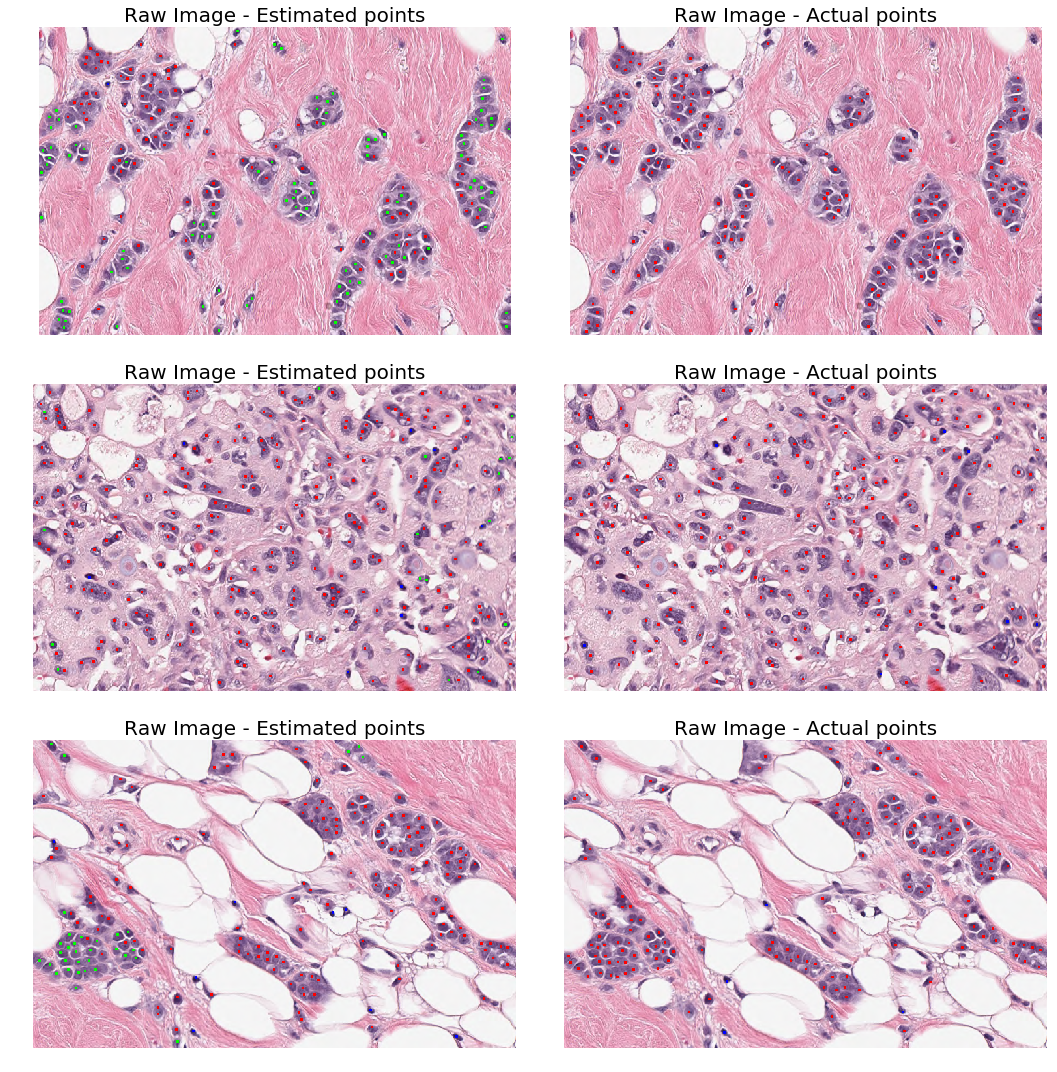

In [5]:
import sys
sys.path.insert(0, '/Users/rb/Google_Drive/Waterloo/projects/cancer_hist/src')
from functions import*
from heat_models import*
import matplotlib.pyplot as plt
% matplotlib inline

bad_images = ['11_Region_4', '91_Region_1', '13_Region_9']  #'135_Region_3', '13_Region_9', '67_Region_10']
f = plt.figure(figsize=(15, 15))

for img_num, img_name in enumerate(bad_images):
    image_loc = '/Users/rb/Documents/waterloo/projects/cancer_hist/final/full_slides/test/'+img_name+'_crop.tif'
    heat_loc='/Users/rb/Documents/waterloo/projects/cancer_hist/final/heat_conv_incp3_192/test/'+img_name+'_crop.npy'
    xml_loc = '/Users/rb/Documents/waterloo/projects/cancer_hist/final/full_slides/test/'+img_name+'_key.xml'

    image = np.asarray(Image.open(image_loc))
    heat = np.load(heat_loc)
    true_pts = get_points_xml(xml_loc)
    points = non_max_supression(heatmap=heat, radius=5, cutoff = .99, stride = 2)
    
    print 2*img_num+1
    sp = f.add_subplot(3, 6//3, 2*img_num+1)
    sp.axis('Off')
    sp.set_title('Raw Image - Estimated points', fontsize=20)
    image2 = np.array(image)
    for row in range(len(points)):
        if points[row, 2] == 1:
            color = [0, 0, 255]
        elif points[row, 2] == 2:
            color = [0, 255, 0]  
        elif points[row, 2] == 3:
            color = [255, 0, 0]
        image2[int(points[row, 0])-2:int(points[row, 0])+2, int(points[row, 1])-2:int(points[row, 1])+2, :] = color
    plt.tight_layout()
    plt.imshow(image2)

    sp = f.add_subplot(3, 6//3, 2*img_num+2)
    sp.axis('Off')
    sp.set_title('Raw Image - Actual points', fontsize=20)
    image2 = np.array(image)
    for row in range(len(true_pts)):
        if true_pts[row, 2] == 1:
            color = [0, 0, 255]
        elif true_pts[row, 2] == 2:
            color = [0, 255, 0]  
        elif true_pts[row, 2] == 3:
            color = [255, 0, 0]
        image2[int(true_pts[row, 0])-2:int(true_pts[row, 0])+2, int(true_pts[row, 1])-2:int(true_pts[row, 1])+2, :] = color
    plt.tight_layout()
    plt.imshow(image2)